In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import ir_datasets

# Load search results
with open("trec_covid_query_results_for_bm25_dirichlet.pkl", "rb") as f:
    search_results = pickle.load(f)

# Load TREC-COVID qrels
dataset = ir_datasets.load("cord19/trec-covid")
real_qrels = {}
for qrel in dataset.qrels_iter():
    if qrel.relevance > 0:
        real_qrels.setdefault(qrel.query_id, set()).add(qrel.doc_id)

# Metric function
def compute_metrics(retrieved, relevant, k=10):
    binary_relevance = [1 if doc in relevant else 0 for doc in retrieved[:k]]
    precision_at_5 = sum(binary_relevance[:5]) / 5
    true_relevance = np.asarray([1 if doc in relevant else 0 for doc in retrieved[:k]]).reshape(1, -1)
    dummy_scores = np.arange(k, 0, -1).reshape(1, -1)
    ndcg_at_10 = ndcg_score(true_relevance, dummy_scores)

    total_relevant = len(relevant)
    bpref = 0
    nonrel_seen = 0
    for rel in binary_relevance:
        if rel == 1:
            bpref += 1 - (nonrel_seen / total_relevant if total_relevant else 0)
        else:
            nonrel_seen += 1
    bpref = bpref / total_relevant if total_relevant else 0
    return precision_at_5, ndcg_at_10, bpref

# Evaluate all three query types
query_fields = ["title", "description", "narrative"]
all_results = []

for query_form in query_fields:
    for qid in search_results["bm25_searcher"].keys():
        if qid in real_qrels:
            relevant_docs = real_qrels[qid]
            bm25_top = search_results["bm25_searcher"][qid][query_form]
            dirichlet_top = search_results["dirichlet_searcher"][qid][query_form]

            bm25_metrics = compute_metrics(bm25_top, relevant_docs)
            dirichlet_metrics = compute_metrics(dirichlet_top, relevant_docs)

            all_results.append({
                "Query ID": qid,
                "Model": "BM25",
                "Query Form": query_form,
                "Precision@5": bm25_metrics[0],
                "NDCG@10": bm25_metrics[1],
                "Bpref": bm25_metrics[2]
            })

            all_results.append({
                "Query ID": qid,
                "Model": "Dirichlet",
                "Query Form": query_form,
                "Precision@5": dirichlet_metrics[0],
                "NDCG@10": dirichlet_metrics[1],
                "Bpref": dirichlet_metrics[2]
            })

# Create DataFrame
queryform_df = pd.DataFrame(all_results)
queryform_df


,Query ID,Model,Query Form,Precision@5,NDCG@10,Bpref
0,1,BM25,title,0.6,0.769846,0.011414
1,1,Dirichlet,title,0.2,0.630930,0.001429
2,2,BM25,title,0.6,0.904398,0.014854
3,2,Dirichlet,title,0.0,0.000000,0.000000
4,3,BM25,title,0.4,0.802269,0.007636
...,...,...,...,...,...,...
295,48,Dirichlet,narrative,1.0,0.995088,0.014549
296,49,BM25,narrative,0.0,0.000000,0.000000
297,49,Dirichlet,narrative,0.2,1.000000,0.003745
298,50,BM25,narrative,0.2,0.773746,0.019684


In [3]:
avg_results = queryform_df.groupby(["Model", "Query Form"])[["Precision@5", "NDCG@10", "Bpref"]].mean().reset_index()
avg_results

,Model,Query Form,Precision@5,NDCG@10,Bpref
0,BM25,description,0.312,0.434958,0.006372
1,BM25,narrative,0.376,0.529107,0.008270
2,BM25,title,0.632,0.754329,0.013814
3,Dirichlet,description,0.336,0.624192,0.006145
4,Dirichlet,narrative,0.196,0.416692,0.003311
5,Dirichlet,title,0.312,0.529974,0.005086


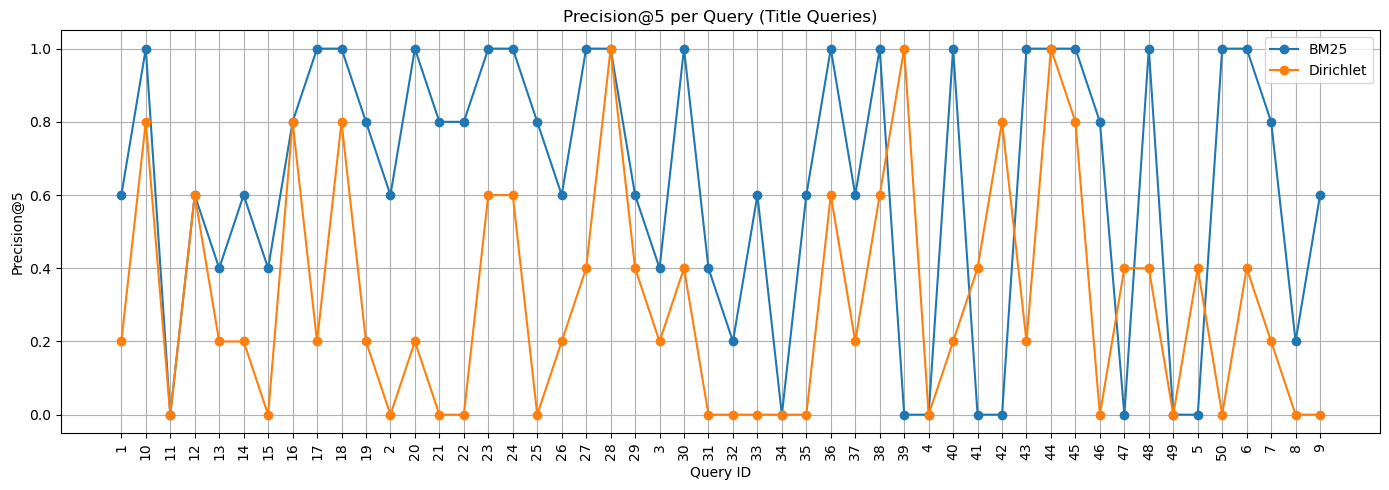

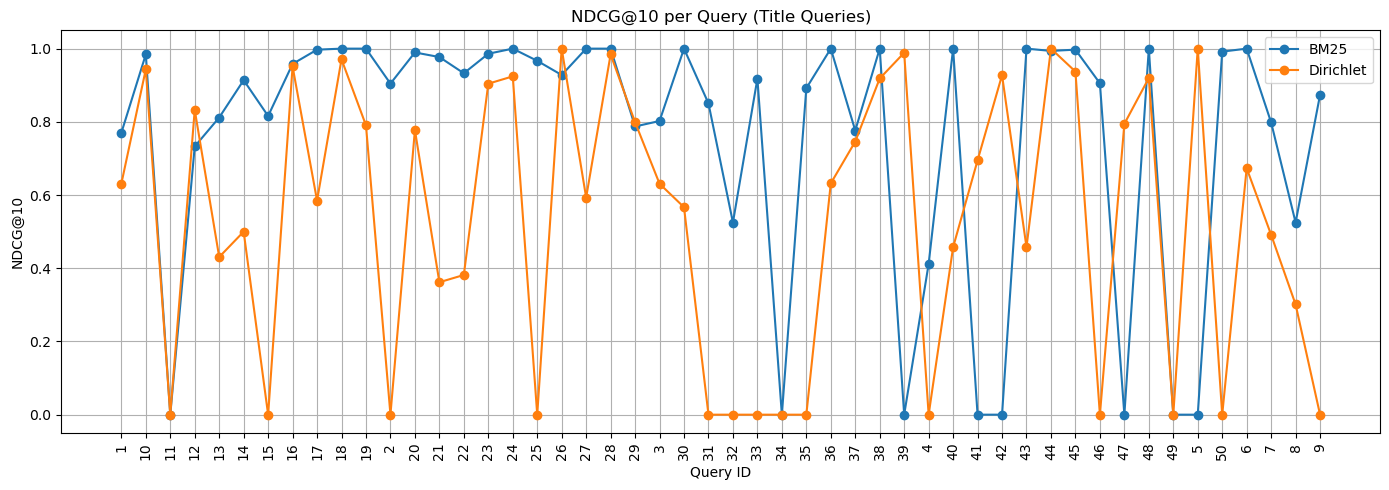

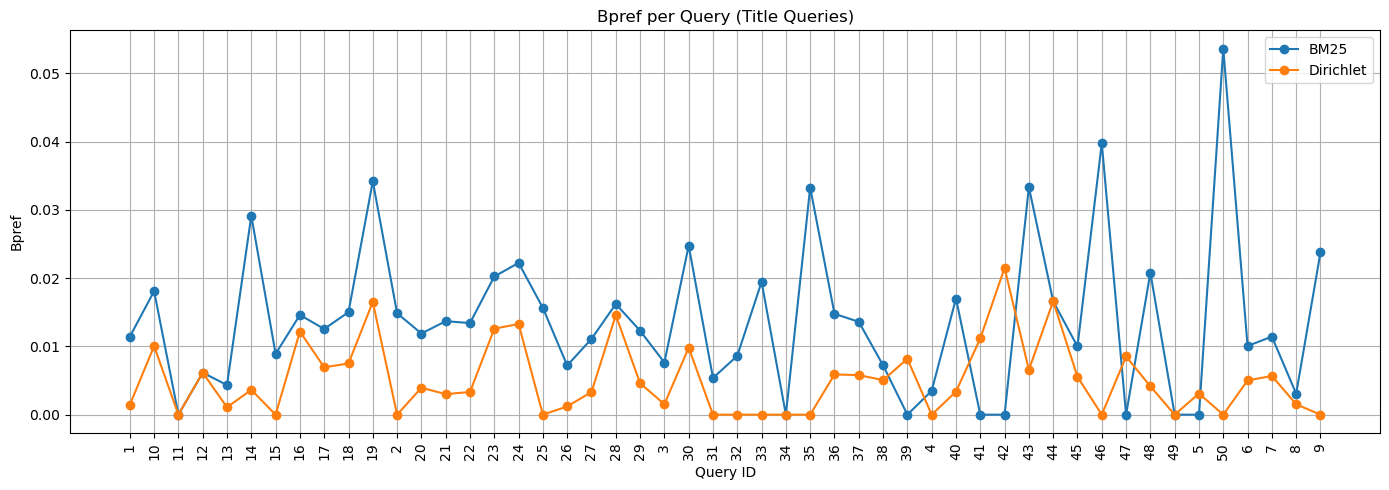

In [5]:
import matplotlib.pyplot as plt

# Get the unique, sorted query IDs
sorted_query_ids = sorted(queryform_df["Query ID"].unique())

# Plot each metric separately
for metric in ["Precision@5", "NDCG@10", "Bpref"]:
    plt.figure(figsize=(14, 5))

    for model in ["BM25", "Dirichlet"]:
        # Filter and sort by Query ID
        filtered = queryform_df[queryform_df["Model"] == model]
        filtered = filtered[filtered["Query Form"] == "title"]  # optional: focus on one query form
        filtered = filtered.sort_values("Query ID")

        metric_vals = filtered[metric].values
        plt.plot(sorted_query_ids, metric_vals, marker='o', label=model)

    plt.title(f"{metric} per Query (Title Queries)")
    plt.xlabel("Query ID")
    plt.ylabel(metric)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
